# Function calling

Function calling is an important capability of large language models. Connecting your model to external tools is at the heart of many LLM applications. In Anyscale Endpoints, you can use the [function calling api](https://docs.anyscale.com/preview/endpoints/text-generation/function-calling) to enable any model to use external tools. This is made possible [through JSON mode](https://www.anyscale.com/blog/anyscale-endpoints-json-mode-and-function-calling-features). However, it is beneficial to have *native* function calling capabilities in your model through fine-tuning on a relevant function calling dataset. This would improve the model's capabilities with intent recognition (understanding when to call and when not to call a tool), structured data formatting (formatting the function call json in the correct way) and function call accuracy (employing the right function with accurate parameters). Only structured data formatting would be guaranteed with JSON-mode-based function calling. Fine-tuning would also be the only systematic way to improve performance on use-case-specific data. 

In this example, we demonstrate fine-tuning on a function calling dataset on  [Glaive's function calling dataset](https://huggingface.co/datasets/glaiveai/glaive-function-calling-v2?row=0) using Anyscale Endpoints. The dataset consists of about 113,000 examples of synthetically generated function calling data.  The dataset composition is given below:

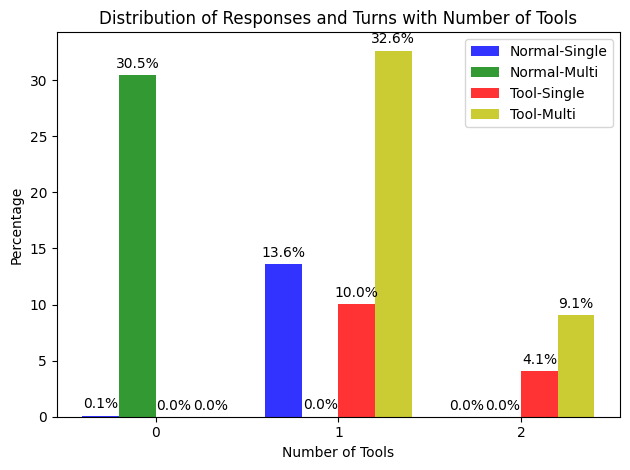

# Table of Contents
1. [Data Preprocessing](#data-preprocessing)
2. [Finetuning](#fine-tuning-with-anyscale-endpoints)
3. [Serving](#serve-the-fine-tuned-model)
4. [Evaluation](#evaluation)

# Data Preprocessing

In [11]:
import datasets
import ray.data 
import sys
from fc_utils.preprocessing import filter_func, initial_mapper, pprint_example
import pprint

Let's load and inspect the first few entries in the dataset. We'll use Ray Data for scalable data processing.

In [19]:
hf_ds = datasets.load_dataset("glaiveai/glaive-function-calling-v2", split="train").shuffle()
train_hf_ds =  hf_ds.select(range(int(len(hf_ds)*0.1)))
test_hf_ds = hf_ds.select(range(int(len(hf_ds)*0.1), int(len(hf_ds)*0.11)))
ray_ds = ray.data.from_huggingface(hf_ds)


In [20]:
pprint.pprint(ray_ds.take(1))

2024-05-14 14:09:45,712	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-05-14_12-07-18_257272_30662/logs/ray-data
2024-05-14 14:09:45,712	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> LimitOperator[limit=1]


- limit=1 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'chat': 'USER: Can you book a flight for me?\n'
          '\n'
          '\n'
          "ASSISTANT: I'm sorry, but I'm currently unable to book flights as "
          "it's an external task and I don't have a function provided for that "
          'task. However, I can help you search for movies based on given '
          'criteria. <|endoftext|>\n'
          '\n'
          '\n',
  'system': 'SYSTEM: You are a helpful assistant with access to the following '
            'functions. Use them if required -\n'
            '{\n'
            '    "name": "search_movies",\n'
            '    "description": "Search for movies based on given criteria",\n'
            '    "parameters": {\n'
            '        "type": "object",\n'
            '        "properties": {\n'
            '            "title": {\n'
            '                "type": "string",\n'
            '                "description": "The title of the movie"\n'
            '            },\n'
            '            "actor"

## Preprocessing


If you notice, each sample has two entires: system and chat. This dataset is already formatted in specific way (e.g. using USER, \<|endoftext|\> and other tokens). But to enable fine-tuning on various open source models we need to convert each row to a more general format like the OpenAI chat format, which is the preferred format for fine-tuning instruction-tuned models on Anyscale ([dataset format guide](https://docs.endpoints.anyscale.com/endpoints/fine-tuning/dataset-prep)). Let's first bring this into the OpenAI conversation format:

In [21]:
from fc_utils.preprocessing import initial_mapper, pprint_example
openai_fmt_ds = ray_ds.map(initial_mapper)
pprint_example(openai_fmt_ds.take(1)[0])

2024-05-14 14:09:46,047	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-05-14_12-07-18_257272_30662/logs/ray-data
2024-05-14 14:09:46,047	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(initial_mapper)] -> LimitOperator[limit=1]


- Map(initial_mapper) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

system: You are a helpful assistant.
user: Can you book a flight for me?
assistant: I'm sorry, but I'm currently unable to book flights as it's an external task and I don't have a function provided for that task. However, I can help you search for movies based on given criteria.
Tool list: [{'name': 'search_movies', 'description': 'Search for movies based on given criteria', 'parameters': {'type': 'object', 'properties': {'title': {'type': 'string', 'description': 'The title of the movie'}, 'actor': {'type': 'string', 'description': 'The actor in the movie'}, 'genre': {'type': 'string', 'description': 'The genre of the movie'}}}}]



We'll now process this conversation format and make it compatible with Anyscale Endpoints. The role "tool" will be converted to the role "user" with a special indicator to highlight that this is a tool response. Further, the tool list will be included in the system prompt with special indicators. The following code block handles the necessary preprocessing.

In [29]:
from collections import defaultdict
cats = ["0", "1", "2"]
# counts = {cat: {"Normal-Single": 0, "Normal-Multi": 0, "Tool-Single": 0, "Tool-Multi": 0} for cat in cats}
counts = {"Normal-Single": [0, 0, 0], "Normal-Multi": [0, 0, 0], "Tool-Single": [0, 0, 0], "Tool-Multi": [0, 0, 0]}
for ex in openai_fmt_ds.iter_rows():
    count = len(eval(ex["tools"]) if ex["tools"] else [] )
    roles = [message["role"] for message in ex["messages"]]
    num_user = len([role for role in roles if role == "user"])
    is_multi = num_user > 1 if roles[-1] != "user" else num_user > 2
    if count == 0:
        if is_multi:
            counts["Normal-Multi"][0] += 1
        else:
            counts["Normal-Single"][0] += 1
    elif count == 1:
        if "tool" not in roles:
            if is_multi:
                counts["Normal-Multi"][1] += 1
            else:
                counts["Normal-Single"][1] += 1
        else:
            if is_multi:
                counts["Tool-Multi"][1] += 1
            else:
                counts["Tool-Single"][1] += 1
    else:
        if "tool" not in roles:
            if is_multi:
                counts["Normal-Multi"][2] += 1
            else:
                counts["Normal-Single"][2] += 1
        else:
            if is_multi:
                counts["Tool-Multi"][2] += 1
            else:
                counts["Tool-Single"][2] += 1
print(counts)

2024-05-14 14:40:49,440	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-05-14_12-07-18_257272_30662/logs/ray-data
2024-05-14 14:40:49,440	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(initial_mapper)]


- Map(initial_mapper) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'Normal-Single': [12, 1540, 0], 'Normal-Multi': [3440, 2, 0], 'Tool-Single': [0, 1131, 459], 'Tool-Multi': [0, 3687, 1025]}


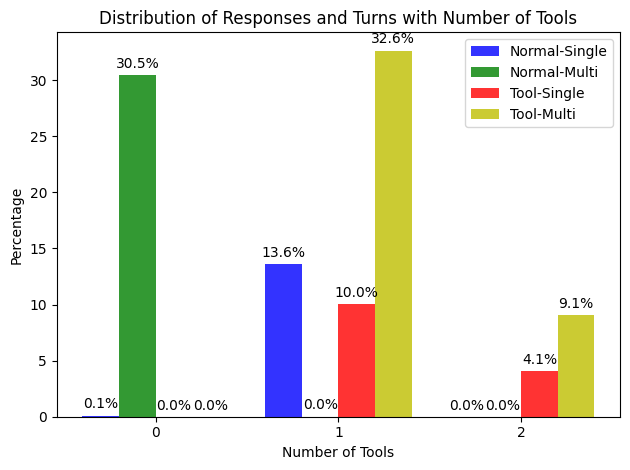

In [57]:
# Number of bars per group
n_groups = 3
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

total_count = openai_fmt_ds.count()
normal_single = 100* np.array(counts["Normal-Single"]) / total_count
normal_multi = 100 * np.array(counts["Normal-Multi"]) / total_count
tool_single = 100 * np.array(counts["Tool-Single"]) / total_count
tool_multi = 100 * np.array(counts["Tool-Multi"]) / total_count

# labels = ['0 Funcs; Normal Response; Single Turn', '0 Funcs; Normal Response; Multi Turn', '1 Func; Normal Response; Single Turn', '1 Func; Normal Response; Multi Turn', '1 Func; Tool Call; Single Turn', '1 Func; Tool Call; Multi Turn', '2 Funcs; Tool Call; Single Turn', '2 Funcs; Tool Call; Multi Turn']
# sizes = [normal_single[0], normal_multi[0], normal_single[1], normal_multi[1], tool_single[1], tool_multi[1], tool_single[2], tool_multi[2]]

# fig, ax = plt.subplots()
# ax.pie(sizes, labels=labels, autopct='%1.2f%%')

rects1 = plt.bar(
    index, normal_single, bar_width, alpha=opacity, color="b", label="Normal-Single"
)
rects2 = plt.bar(
    index + bar_width,
    normal_multi,
    bar_width,
    alpha=opacity,
    color="g",
    label="Normal-Multi",
)
rects3 = plt.bar(
    index + 2 * bar_width,
    tool_single,
    bar_width,
    alpha=opacity,
    color="r",
    label="Tool-Single",
)
rects4 = plt.bar(
    index + 3 * bar_width,
    tool_multi,
    bar_width,
    alpha=opacity,
    color="y",
    label="Tool-Multi",
)


# Adding percentages on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%', 
                    xy=(rect.get_x() + rect.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
for rect in [rects1, rects2, rects3, rects4]:
    add_labels(rect)

# add_labels([rects1, rects2, rects3, rects4])


plt.xlabel("Number of Tools")
plt.ylabel("Percentage")
plt.title("Distribution of Responses and Turns with Number of Tools")
plt.xticks(index + bar_width * 1.5, [0, 1, 2])
plt.legend()

plt.tight_layout()
plt.show()


In [41]:
normal_multi

[3440, 2, 0]

([<matplotlib.patches.Wedge at 0x7f9baa8d7d00>,
 [Text(1.0999938740253923, 0.00367111789644879, '0 Funcs; Normal Response; Single Turn'),
  Text(0.6278116925370636, 0.9032455251556731, '0 Funcs; Normal Response; Multi Turn'),
  Text(-0.7717369238046032, 0.7838508279236607, '1 Func; Normal Response; Single Turn'),
  Text(-1.0277984779914322, 0.3919569984558199, '1 Func; Normal Response; Multi Turn'),
  Text(-1.098667486424549, 0.054127204560774536, '1 Func; Tool Call; Single Turn'),
  Text(-0.3040570582578851, -1.0571420459538827, '1 Func; Tool Call; Multi Turn'),
  Text(0.842889211432311, -0.7067798647747524, '2 Funcs; Tool Call; Single Turn'),
  Text(1.0556066784902172, -0.3093453415308713, '2 Funcs; Tool Call; Multi Turn')],
 [Text(0.5999966585593047, 0.0020024279435175217, '0.11%'),
  Text(0.34244274138385283, 0.4926793773576398, '30.45%'),
  Text(-0.420947412984329, 0.4275549970492694, '13.63%'),
  Text(-0.5606173516316902, 0.2137947264304472, '0.02%'),
  Text(-0.5992731744133902, 

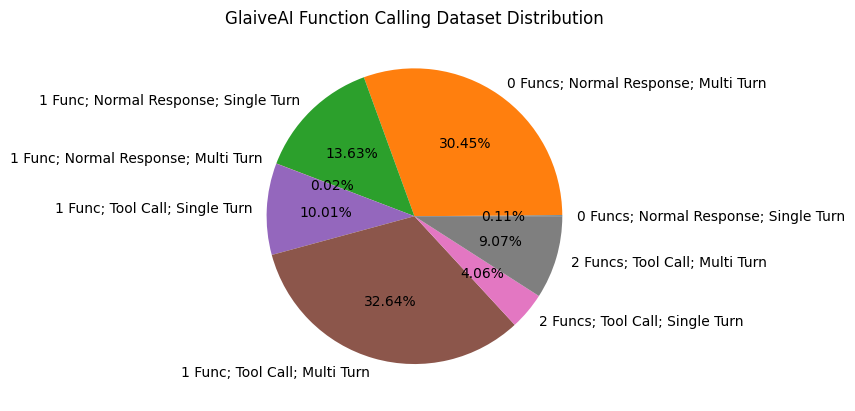

In [46]:
# convert into pie chart
labels = ['0 Funcs; Normal Response; Single Turn', '0 Funcs; Normal Response; Multi Turn', '1 Func; Normal Response; Single Turn', '1 Func; Normal Response; Multi Turn', '1 Func; Tool Call; Single Turn', '1 Func; Tool Call; Multi Turn', '2 Funcs; Tool Call; Single Turn', '2 Funcs; Tool Call; Multi Turn']
sizes = [normal_single[0], normal_multi[0], normal_single[1], normal_multi[1], tool_single[1], tool_multi[1], tool_single[2], tool_multi[2]]

fig, ax = plt.subplots()
plt.title("GlaiveAI Function Calling Dataset Distribution")
ax.pie(sizes, labels=labels, autopct='%1.2f%%')

In [17]:
ex["tools"]

In [9]:
from fc_utils.preprocessing import preprocess
processed_ds = preprocess(ray_ds)
pprint_example(processed_ds.take(1)[0])

2024-05-14 12:49:50,775	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-05-14_12-07-18_257272_30662/logs/ray-data
2024-05-14 12:49:50,775	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(initial_mapper)->Map(final_mapper)->Filter(filter_func)->MapBatches(drop_columns)] -> LimitOperator[limit=1]


- Map(initial_mapper)->Map(final_mapper)->Filter(filter_func)->MapBatches(drop_columns) 1:   0%|          | 0/…

- limit=1 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

system: You are a helpful assistant with access to the following functions. Use them if required -
{
    "name": "search_books",
    "description": "Search for books based on title and author",
    "parameters": {
        "type": "object",
        "properties": {
            "title": {
                "type": "string",
                "description": "The title of the book"
            },
            "author": {
                "type": "string",
                "description": "The author of the book"
            }
        },
        "required": [
            "title"
        ]
    }
}

user: I am looking for a book but I can't remember the full title. I think it was something like "The Great" and it was written by Fitzgerald.
assistant: <functioncall> {"name": "search_books", "arguments": '{"title": "The Great", "author": "Fitzgerald"}'} 
user: <functionresponse> {"results": [{"title": "The Great Gatsby", "author": "F. Scott Fitzgerald", "publisher": "Charles Scribner's Sons", "year": 19

In [19]:
hf_ds = hf_ds.remove_columns(["system", "chat"]) # drop the original columns

In [20]:
hf_ds

Dataset({
    features: ['messages'],
    num_rows: 11296
})

# Filtering
There are some erraneous entries in the glaive dataset where the assistant's response is repeated. In our processed dataset, these entries can look as follows:

{.......'content': 'Sure, let me help you with that. <functioncall> {"name": "track_package", "arguments": \'{"tracking_number": "123456789"}\'} ', 'role': 'assistant'}, {'content': '<functioncall> {"name": "track_package", "arguments": \'{"tracking_number": "123456789"}\'} ', 'role': 'assistant'.....}


There are also some valid entries where the assistant's  text response and function call are placed in two consecutive "ASSISTANT: .." response entries in the dataset. We use a conservative filter function here that simply removes all entries where the same role is found consecutively in the chat. While there is room for improvement here, this affects only a small chunk of the data and gives us a much cleaner subset to feed into our model.

In [21]:
hf_ds = hf_ds.filter(filter_func)

In [22]:
hf_ds

Dataset({
    features: ['messages'],
    num_rows: 10561
})

# (Optional) Dataset format check


Here, we validate that the dataset is in the right format. When you launch a fine-tuning job through a model endpoint, it is important to thoroughly check that the dataset follows the permitted format. Anyscale Endpoints provides a [helper function](https://docs.endpoints.anyscale.com/endpoints/fine-tuning/dataset-prep#context-length) to check that the dataset is in the right format. 

In [9]:
from fc_utils.data_format_checker import convert_message_list_to_text, FormattingError

for i, msg in enumerate(hf_ds): 
    try:
        convert_message_list_to_text(msg["messages"])
    except Exception as e:
        raise FormattingError(f"Error in example {i}: {e}")


# Train Validation Split

Let's make a train and validation split and save the datasets in the jsonl format.

In [23]:
hf_ds = hf_ds.train_test_split(test_size=0.2)

In [24]:
hf_ds

DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 8448
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 2113
    })
})

In [25]:
hf_ds["train"].to_json("glaiveai-function-calling-v2-train.jsonl")
hf_ds["test"].to_json("glaiveai-function-calling-v2-val.jsonl")

Creating json from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

5324907

In [28]:
hf_ds["train"][:2]

{'messages': [[{'content': 'You are a helpful assistant with access to the following functions. Use them if required -\n{\n    "name": "send_email",\n    "description": "Send an email",\n    "parameters": {\n        "type": "object",\n        "properties": {\n            "recipient": {\n                "type": "string",\n                "description": "The email address of the recipient"\n            },\n            "subject": {\n                "type": "string",\n                "description": "The subject of the email"\n            },\n            "message": {\n                "type": "string",\n                "description": "The body of the email"\n            }\n        },\n        "required": [\n            "recipient",\n            "subject",\n            "message"\n        ]\n    }\n}\n',
    'role': 'system'},
   {'content': 'Hey, can you book a flight for me?', 'role': 'user'},
   {'content': "I'm sorry, but I don't have the capability to book flights. My current function all

In [13]:
# Optional: create a small dataset for testing out fine-tuning
hf_ds["train"].select(range(100)).to_json("glaiveai-function-calling-v2-train-small.jsonl")
hf_ds["test"].select(range(100)).to_json("glaiveai-function-calling-v2-val-small.jsonl")


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

258554

# Fine-tuning with Anyscale endpoints


First, obtain your crendentials from the [Anyscale platform](https://console.anyscale.com/v2/) and upload the training and validation files in the [fine-tuning tab](https://console.anyscale.com/v2/fine-tuning?fine-tuning-tab=files). Make a note of the file IDs for each. This will be passed to the fine-tuning job.

In [53]:
ANYSCALE_API_KEY = "esecret_yourKeyHere"  # from https://console.anyscale.com/credentials

In [1]:
import openai
# Anyscale Endpoints are OpenAI compatible
client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key = "esecret_yourKeyHere" 
)

Let's now launch a fine-tuning job for 4 epochs. The expected time for this job is < 3 hours.

In [ ]:
# other parameters like context length will be chosen appropriately based on dataset size
client.fine_tuning.jobs.create(
    model="meta-llama/Meta-Llama-3-8B-Instruct",
    hyperparameters={"n_epochs": 4},
    # replace with the actual file ids!
    training_file="file_trainingFileId",
    validation_file="file_validationFileId",
)

# Serve the fine-tuned model

To serve the fine-tuned model, you just need to navigate to the "Serving" section on the Anyscale Platform. Your fine-tuned model should already be visible in the list of available models! 

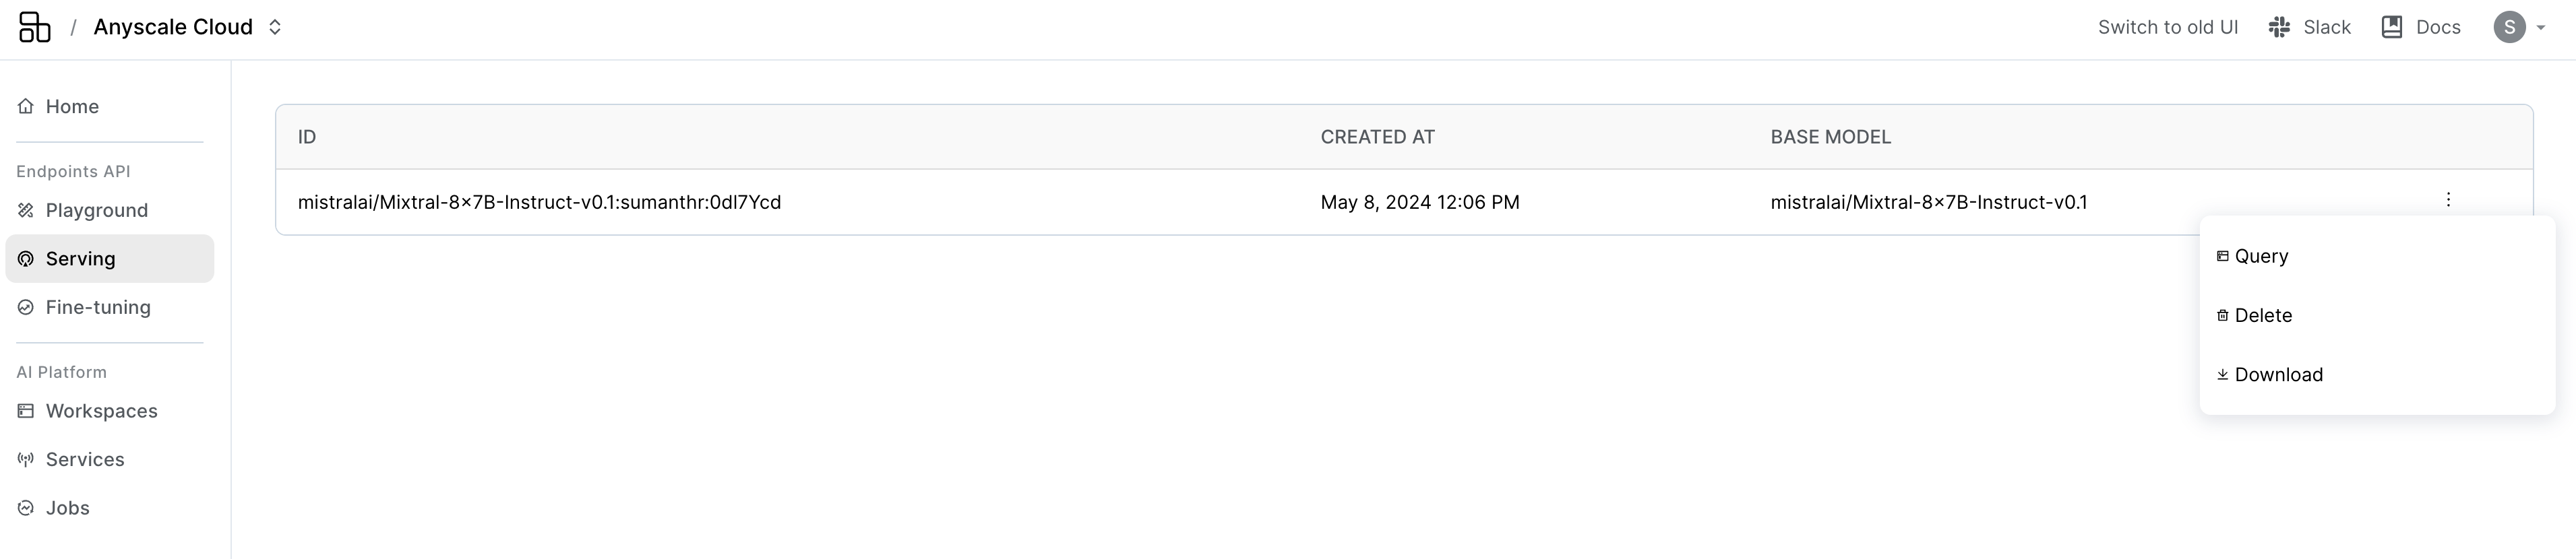

As in the above image, click on the three dots and then click on "Query". This will provide you the starter code to interact with the model via curl, python, etc. 

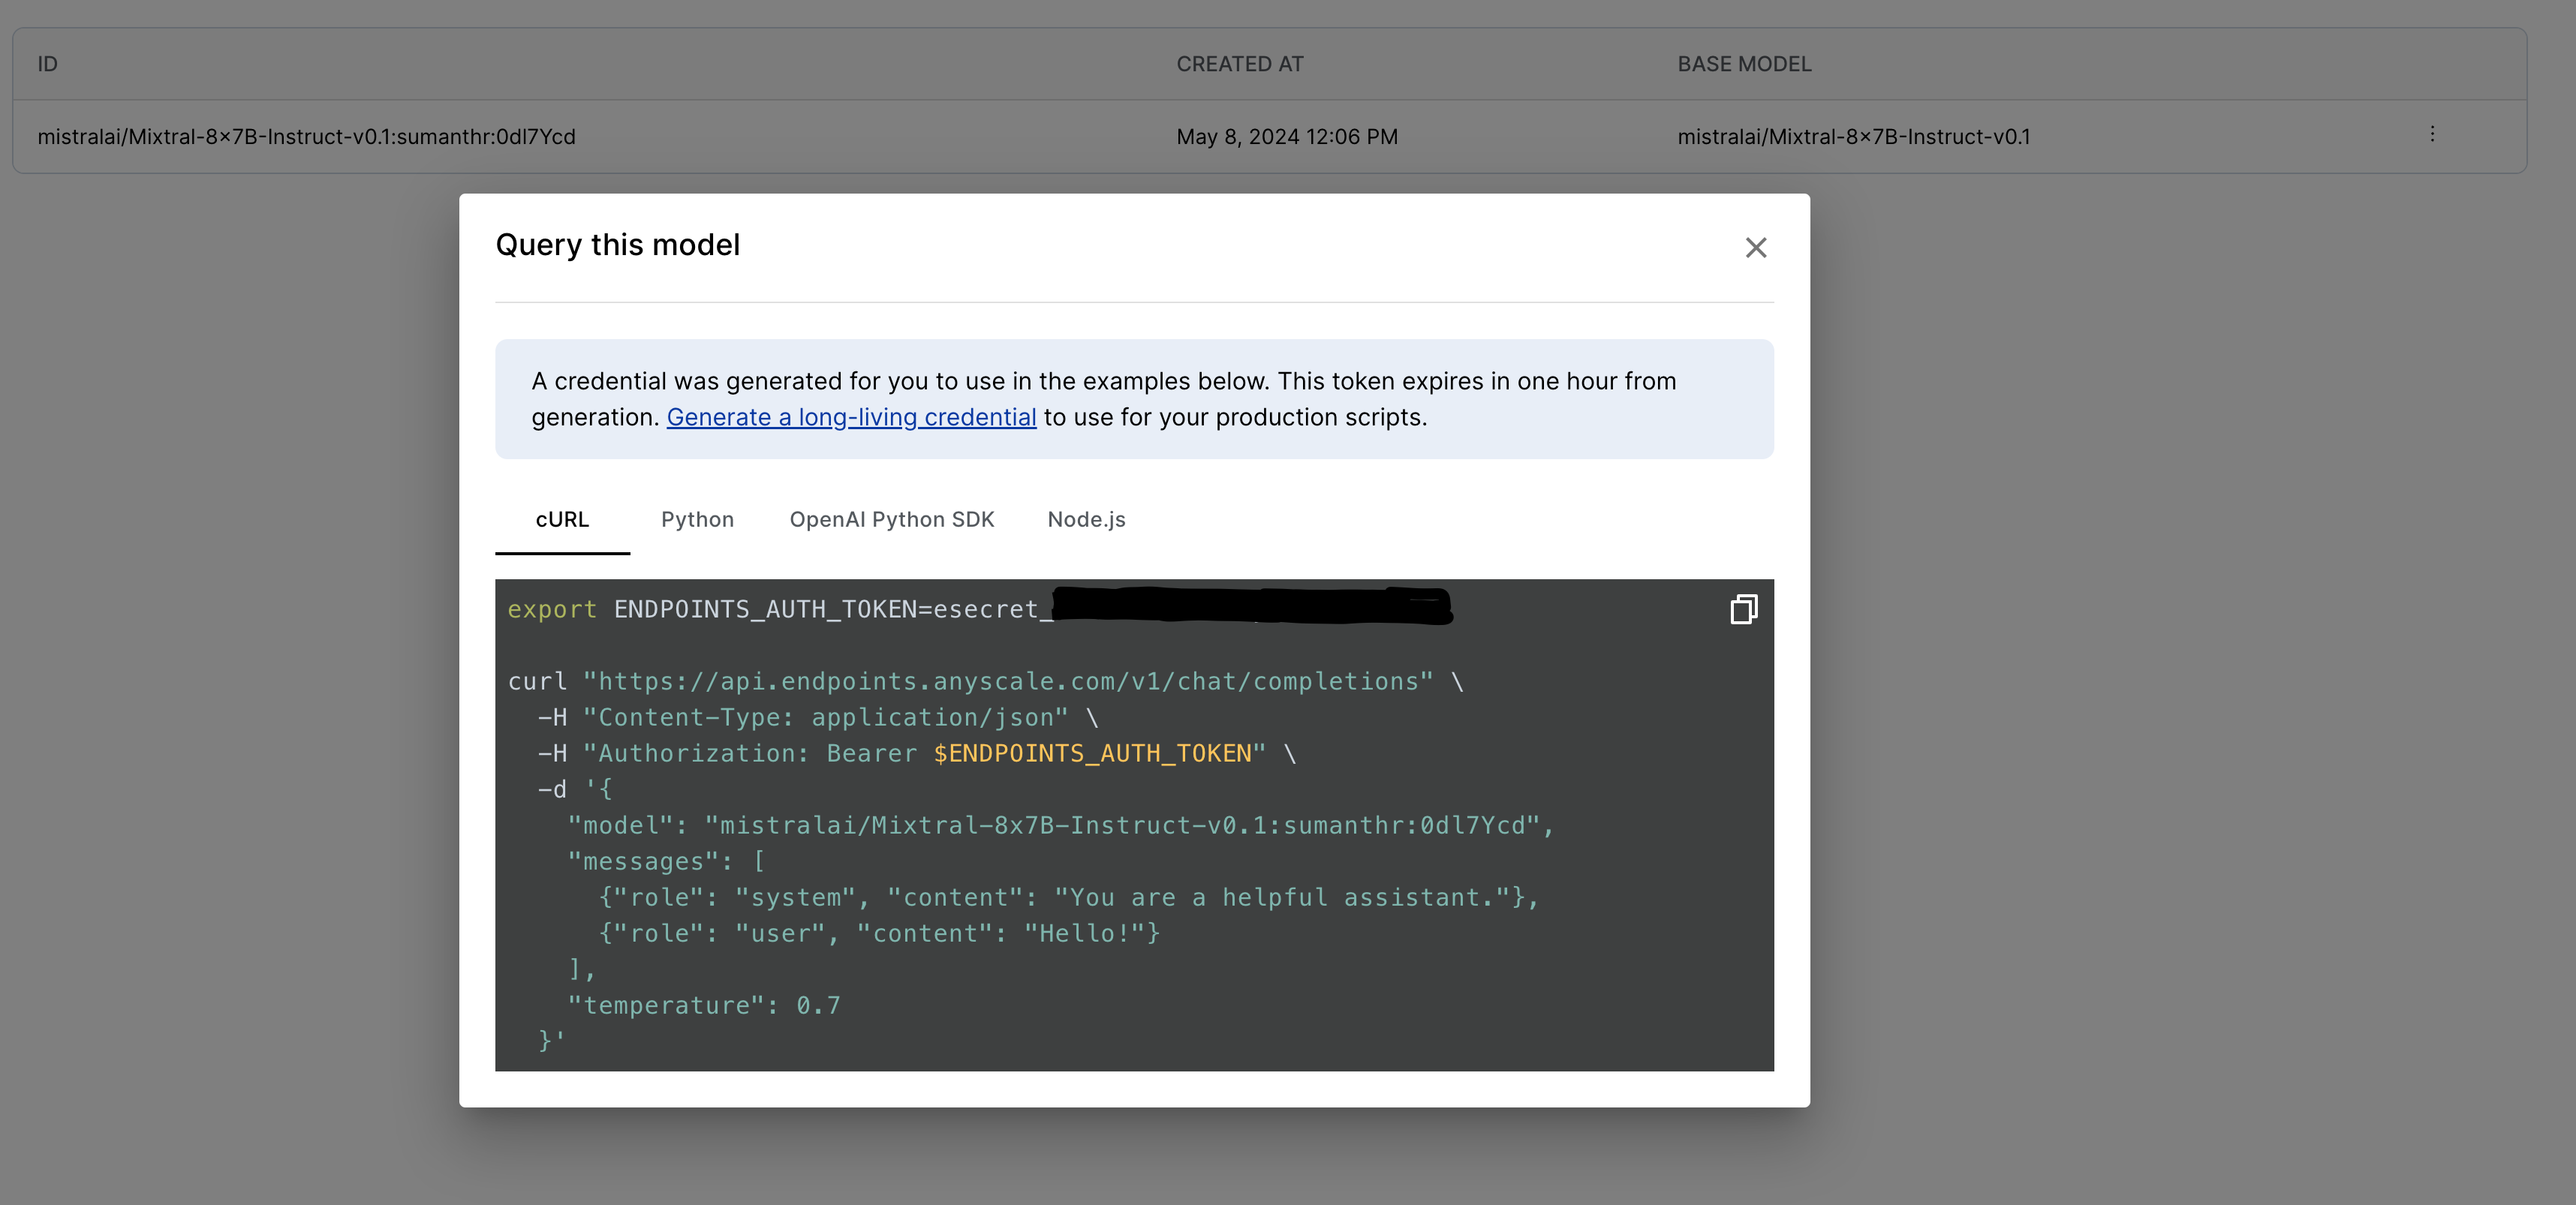

# Evaluation

Let's evaluate our trained model. We will use GPT-4 as a baseline. Evaluation of function calling capability is non-trivial, given that we're looking to extract structured data from an unpredictable unstructured stream of text. In this example, we build a simple test set on the same training task: We sample 200 entries from the Glaiveai dataset that were not used for training or validation. 


## Evaluation strategy

We will use the following simple evaluation strategy: The models are evaluated on the accuracy metric and their responses are graded as accurate if their response for each assistant entry in the conversation is correct. A response is graded as correct if:
1. In case the ground truth response has no function call, then the model's response should also not have a function call. In almost all cases (except dataset formatting issues), there would be a non-empty content in the ground truth response, and thus the model's response should also be non-empty.
2. In case the ground truth response has a function call, then the model's response should also have a function call. We do not check for the content of the response here. This would be evaluated differently for openai and Anyscale (Llama-3) models:
    - In the case of GPT-4, the function call is readily available in the form of function name and function arguments. We do simple json processing to extract arguments from the raw string. 
    - In the case of Llama-3, the function call is in a raw string. Example: "<functioncall> {"name": "get_value", "arguments": '{"variable": "x"}'}". THe raw string is processed using the `get_tool_call_from_response` helper function defined below. For consistency, the arguments field is processed in the same way as with OpenAI.

## Dataset formatting
We follow the same preprocessing as during training for the Llama-3-8B model hosted on Anyscale. For GPT-4, the tool calls and tool responses are parsed and formatted in the OpenAI format. 

In [24]:
test_ds = datasets.load_dataset("glaiveai/glaive-function-calling-v2", split="train[15%:16%]")

In [25]:
import datasets
test_ds = datasets.load_dataset("glaiveai/glaive-function-calling-v2", split="train[15%:16%]")
print("Length: ", len(test_ds))
test_ds = test_ds.map(mapper) 
test_ds = test_ds.filter(filter_func)
print("Length: ", len(test_ds))
test_ds = test_ds.select(range(200)) # select a smaller subset for testing
print("Length: ", len(test_ds))


Length:  1130
Length:  1052
Length:  200


## Helper functions
We develop a few helper functions for parsing function calls in assistant responses and to extract the function jsons from the system message.

In [26]:
from fc_utils.function_extraction_utils import extract_functions, get_tool_call_from_response, FunctionCallNotFoundError

We process the test dataset to have the following fields: 
1. `openai_user_messages` : the system and list of user and tool messages in the conversation for gpt-4. The user messages will be fed to the model one by one. Note that function responses have to be designated with the role "tool" here, while this isn't the case with Llama-3-8B.
2. `anyscale_user_messages`: the system and list of user messages in the conversation for Anyscale
3. `openai_functions`: the list of tools to pass to the OpenAI model. Note that in the case of LLama-3-8B we pass the list of functions in the system message as a string
4. `ground_truths` : the list of ground truth assistant responses in the conversation. 

In [27]:
modified_ds = []
for example in test_ds:
    messages = example["messages"]
    example["openai_user_messages"] = []
    example["anyscale_user_messages"] = []
    openai_system_msg = {"role": "system", "content": "You are a helpful assistant."} # default
    example["openai_user_messages"].append(openai_system_msg)
    example["anyscale_user_messages"].append(messages[0])
    functions = extract_functions(example["system"])
    # Some functions may not have parameters. Fix them
    for fn in functions:
        if not fn["parameters"]:
            fn["parameters"] = {
                "type": "object",
                "properties": {},
                "required": [],
            }
    example["openai_functions"] = functions
    
    for i in range(1, len(messages), 2):
        previous_message = messages[i-1]
        if previous_message["role"] == "assistant" and "<functioncall>" in previous_message["content"]:
            # openai's message format requires the function name. which is only present in the previous assistant response.
            _, previous_tool_call = get_tool_call_from_response(previous_message["content"], eos_present=False)
            openai_message = {
                    "role": "tool",
                    "name": previous_tool_call["name"],
                    "content": messages[i]["content"],
                }
            example["openai_user_messages"].append(openai_message)
        else:
            example["openai_user_messages"].append(messages[i])
        example["anyscale_user_messages"].append(messages[i])
    example["ground_truths"] = []
    for i in range(2, len(messages), 2): # assistant messages
        if "<functioncall>" in messages[i]["content"]:
            content, tool_call = get_tool_call_from_response(messages[i]["content"], eos_present=False)
            example["ground_truths"].append({"role": messages[i]["role"], "content": content, "tool_call": tool_call})
        else:
            example["ground_truths"].append({"role": messages[i]["role"], "content": messages[i]["content"], "tool_call": None})
    # example.pop("messages") #remove the original full conversation
    modified_ds.append(example)



# Clients and Parser

We define two parser classes `AnyscaleResponseParser` and `OpenAIResponseParser` below to send messages to the respective endpoints and parse the result. With the `AnyscaleResponseParser`, we use the helper functions defined previously to obtain the function call json from the response text.

In [28]:
import json 
import re
from fc_utils.response_parsers import OpenAIResponseParser, AnyscaleResponseParser, ERROR_OUTPUT

In [29]:
from fc_utils.eval_utils import is_match, parse_and_eval


# Evaluate!

Initialize parsers and evaluate GPT-4 and Llama-3-8B on the test set.

In [30]:
OPENAI_API_KEY = "yourApiKeyHere" # enter your openai key here

In [36]:
from tqdm import tqdm
# evaluate gpt-4
openai_parser = OpenAIResponseParser(api_key=OPENAI_API_KEY, api_base="https://api.openai.com/v1", model="gpt-4")
anyscale_parser = AnyscaleResponseParser(api_key=ANYSCALE_API_KEY, api_base="https://serve-session-ljyv94qdghjth7ldigbzfhhjxx.i.anyscaleuserdata.com/v1", model="meta-llama/Meta-Llama-3-8B-Instruct:glaiveai_v1:1234") # make sure to not add a stray / at the end!


In [37]:
anyscale_accuracy = 0
openai_accuracy = 0
total_count = 0 # count can exclude api error outputs
save_dicts = []
pbar = tqdm(total=len(modified_ds), desc="Evaluating models..")
save_interval = 50
i = 0

Evaluating models..:   0%|          | 0/200 [01:22<?, ?it/s]


In [41]:
import pickle

while i< len(modified_ds):
    example = modified_ds[i]
    i += 1
    openai_messages = example["openai_user_messages"]
    anyscale_messages = example["anyscale_user_messages"]
    openai_tools = [{"type": "function", "function": fn} for fn in example["openai_functions"]]
    openai_conv, openai_is_match = parse_and_eval(openai_parser, openai_messages, example["ground_truths"], tools=openai_tools)
    anyscale_conv, anyscale_is_match = parse_and_eval(anyscale_parser, anyscale_messages, example["ground_truths"])
    save_dicts.append({
        "openai": openai_conv,
        "anyscale": anyscale_conv,
        "ground_truths": example["ground_truths"],
        "example": example,
        "anyscale_is_match": anyscale_is_match,
        "openai_is_match": openai_is_match 
    })
    pbar.set_description("Iter: %d, OpenAI: %d, Anyscale: %d" % (i, openai_accuracy, anyscale_accuracy))
    pbar.update(1)

    if openai_conv is None or anyscale_conv is None: # skip if api errors out
        continue

    if anyscale_is_match:
        anyscale_accuracy += 1
    
    if openai_is_match:
        openai_accuracy += 1
    
    if (i+1) % save_interval == 0:
        with open("evaluation_results.pkl", "wb") as f:
            pickle.dump(save_dicts, f)
    
    total_count += 1




Iter: 70, OpenAI: 62, Anyscale: 62:  34%|███▍      | 68/200 [1:24:00<1:53:12, 51.46s/it]  

Error: Error code: 400 - {'error': {'message': "Invalid schema for function 'find_common_elements': In context=('properties', 'arrays', 'items'), array schema missing items", 'type': 'invalid_request_error', 'param': 'tools[0].function.parameters', 'code': 'invalid_function_parameters'}}
Error: Error code: 400 - {'error': {'message': "Invalid schema for function 'find_common_elements': In context=('properties', 'arrays', 'items'), array schema missing items", 'type': 'invalid_request_error', 'param': 'tools[0].function.parameters', 'code': 'invalid_function_parameters'}}
Error: Error code: 400 - {'error': {'message': "Invalid schema for function 'find_common_elements': In context=('properties', 'arrays', 'items'), array schema missing items", 'type': 'invalid_request_error', 'param': 'tools[0].function.parameters', 'code': 'invalid_function_parameters'}}
Error: Error code: 400 - {'error': {'message': "Invalid schema for function 'find_common_elements': In context=('properties', 'arrays

Iter: 200, OpenAI: 186, Anyscale: 185:  99%|█████████▉| 198/200 [2:25:55<00:52, 26.21s/it]  

In [39]:
i

41